# Setup

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [67]:
# Load cleaned data
filepath = '../data/'
df = pd.read_csv(filepath + 'cleaned_dataset.csv')

In [93]:
print(df.shape)
df.head()

(109950743, 15)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,datetime,date,time,day,category_2
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,none,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,none,2019-10-01 00:00:00+00:00,2019-10-01,00:00:00,Tuesday,None
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,2019-10-01 00:00:00+00:00,2019-10-01,00:00:00,Tuesday,environment
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,none,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture,2019-10-01 00:00:01+00:00,2019-10-01,00:00:01,Tuesday,living_room
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,2019-10-01 00:00:01+00:00,2019-10-01,00:00:01,Tuesday,notebook
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics,2019-10-01 00:00:04+00:00,2019-10-01,00:00:04,Tuesday,smartphone


# Prepare the data for training

Since we are interested in lowering the shopping cart abandonment rate, therefore increasing the conversion rate from cart to purchase, we will retain a subset of the data on customer activity where an item was placed in the cart.

In [94]:
# Get activity with cart and purchase events
sliced_cart_purchase = df.loc[df['event_type'].isin(['cart','purchase'])]

In [95]:
# Check number of rows
len(sliced_cart_purchase)

5615234

In [96]:
# Add `converted` column and set 1 if purchased or 0 if not purchased 
sliced_cart_purchase['converted'] = np.where(sliced_cart_purchase['event_type'] == 'purchase', 1, 0)

In [97]:
# Group events by user_session and product_id and retain the max value in 'converted' to determine if the product was purchased in the same user_session
sliced_cart_purchase['converted'] = sliced_cart_purchase.groupby(['user_session','product_id'])['converted'].transform('max')

In [98]:
# Keep cart events and drop duplicates
sliced_cart_purchase = sliced_cart_purchase.loc[sliced_cart_purchase['event_type'] == 'cart'].drop_duplicates(['user_session','product_id','converted'])

In [99]:
# The dataframe should now only have cart events
sliced_cart_purchase['event_type'].value_counts()

cart    2681986
Name: event_type, dtype: int64

In [100]:
# Check updated number of rows
len(sliced_cart_purchase)

2681986

In [101]:
sliced_cart_purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,datetime,date,time,day,category_2,converted
331,2019-10-01 00:05:14 UTC,cart,5100816,2053013553375346967,none,xiaomi,29.51,550121407,6f623695-9581-4633-813f-825b8760c7ae,none,2019-10-01 00:05:14+00:00,2019-10-01,00:05:14,Tuesday,None,0
583,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,2019-10-01 00:09:33+00:00,2019-10-01,00:09:33,Tuesday,smartphone,1
680,2019-10-01 00:11:00 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,2019-10-01 00:11:00+00:00,2019-10-01,00:11:00,Tuesday,audio,0
1325,2019-10-01 02:17:59 UTC,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,electronics,2019-10-01 02:17:59+00:00,2019-10-01,02:17:59,Tuesday,smartphone,0
1654,2019-10-01 02:19:36 UTC,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,electronics,2019-10-01 02:19:36+00:00,2019-10-01,02:19:36,Tuesday,smartphone,1


In [102]:
# Count number of retained converted and not converted events
print('Purchased/Converted:', len(sliced_cart_purchase.loc[sliced_cart_purchase['converted'] == 1]))
print('Not purchased/Not converted:', len(sliced_cart_purchase.loc[sliced_cart_purchase['converted'] == 0]))

Purchased/Converted: 1018645
Not purchased/Not converted: 1663341


In [103]:
# Get relevant feature columns for training
data = sliced_cart_purchase[['brand','price','category','category_2','day','converted']]

In [104]:
data.head()

,brand,price,category,category_2,day,converted
331,xiaomi,29.51,none,None,Tuesday,0
583,apple,515.67,electronics,smartphone,Tuesday,1
680,apple,161.98,electronics,audio,Tuesday,0
1325,samsung,174.76,electronics,smartphone,Tuesday,0
1654,huawei,258.21,electronics,smartphone,Tuesday,1


In [105]:
data.shape

(2681986, 6)

# Model training
Some parts of this section used this as reference: https://github.com/andypwyu/eCommerce-behavior/blob/master/eCommerce%20behavior%20data%20from%20multi%20category%20store.ipynb

## Rebalance the classes

In [9]:
# Separate into two dataframes for resampling
converted = data.loc[data['converted'] == 1]
not_converted = data.loc[data['converted'] == 0]

In [10]:
print(len(converted))
print(len(not_converted))

1018645
1663341


In [11]:
# Get n_samples for each set
n_samples = 1000000  
converted_downsampled = resample(converted, replace = False, n_samples = n_samples, random_state = 101)
not_converted_downsampled = resample(not_converted, replace = False, n_samples = n_samples, random_state = 101)

In [12]:
# Merge training sets
downsampled = pd.concat([converted_downsampled, not_converted_downsampled])
downsampled['converted'].value_counts()

1    1000000
0    1000000
Name: converted, dtype: int64

## Prepare variables for training

### Set features

In [13]:
features = downsampled[['brand','price','category','category_2','day']]

In [14]:
features.head()

,brand,price,category,category_2,day
179477,apple,760.10,electronics,smartphone,Saturday
101887,apple,358.57,electronics,smartphone,Sunday
99607,samsung,131.76,electronics,smartphone,Sunday
469190,apple,358.54,electronics,smartphone,Wednesday
755707,none,25.48,none,NaN,Friday


#### Encode categorical variables
Categorical features: brand, categories, day

In [13]:
# Used LabelEncoder as there is a lot of categories per feature > ref: https://datascience.stackexchange.com/a/40908
features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'category'] = LabelEncoder().fit_transform(downsampled.loc[:,'category'].copy())
features.loc[:,'category_2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_2'].copy())
features.loc[:,'day'] = LabelEncoder().fit_transform(downsampled.loc[:,'day'].copy())

In [14]:
features.head()

,brand,price,category,category_2,day
179477,150,760.10,7,40,2
101887,150,358.57,7,40,3
99607,2300,131.76,7,40,3
469190,150,358.54,7,40,6
755707,1901,25.48,11,57,0


### Set target

In [15]:
target = downsampled['converted'].values
target

array([1, 1, 1, ..., 0, 0, 0])

## Save dataset for deployment to cloud-based ML platform

In [45]:
# Create new dataset with encoded features
out = features.copy()
out['target'] = downsampled['converted'].values
out.head()

,brand,price,category,category_2,day,target
179477,apple,760.10,electronics,smartphone,Saturday,1
101887,apple,358.57,electronics,smartphone,Sunday,1
99607,samsung,131.76,electronics,smartphone,Sunday,1
469190,apple,358.54,electronics,smartphone,Wednesday,1
755707,none,25.48,none,NaN,Friday,1


In [17]:
out.shape

(2000000, 6)

In [18]:
features = out[['brand','price','category','category_2','day']]
target = out['target'].values

In [22]:
print(len(features))
features.head()

2000000


,brand,price,category,category_2,day
179477,apple,760.10,electronics,smartphone,Saturday
101887,apple,358.57,electronics,smartphone,Sunday
99607,samsung,131.76,electronics,smartphone,Sunday
469190,apple,358.54,electronics,smartphone,Wednesday
755707,none,25.48,none,NaN,Friday


In [21]:
print(len(target))
target

2000000


array([1, 1, 1, ..., 0, 0, 0])

In [23]:
# Randomly assign records into training and testing sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = test_size, random_state = 123)

In [26]:
# Export training set
print(len(X_train))
print(len(y_train))
training_set = X_train.copy()
training_set['target'] = y_train

1400000
1400000


In [27]:
print(training_set.shape)
training_set.head()

(1400000, 6)


,brand,price,category,category_2,day,target
1262482,apple,1421.76,electronics,smartphone,Friday,0
2600328,apple,196.30,electronics,audio,Friday,1
829574,samsung,266.56,electronics,smartphone,Sunday,1
2001376,arg,59.18,appliances,kitchen,Sunday,1
1896653,panasonic,87.49,none,NaN,Sunday,1


In [33]:
type(y_train)

numpy.ndarray

In [28]:
# Save to csv
training_set.to_csv('training_set.csv', index=False)

In [41]:
target_df = pd.DataFrame(y_train)
target_df.columns = ['target']
target_df.head()

,target
0,0
1,1
2,1
3,1
4,1


In [42]:
# Save separate csv for X and y data
X_train.to_csv('data.csv', index=False)
target_df.to_csv('target.csv', index=False)

In [43]:
print(X_train.shape)
print(target_df.shape)

(1400000, 5)
(1400000, 1)


## Train XGBoost classifier

In [142]:
# Fit classifer
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [143]:
# Get confusion matrix
confusion_matrix(y_test, y_pred_xgb)

array([[178606, 121770],
       [ 87597, 212027]])

In [144]:
# Get classification report
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63    300376
           1       0.64      0.71      0.67    299624

    accuracy                           0.65    600000
   macro avg       0.65      0.65      0.65    600000
weighted avg       0.65      0.65      0.65    600000



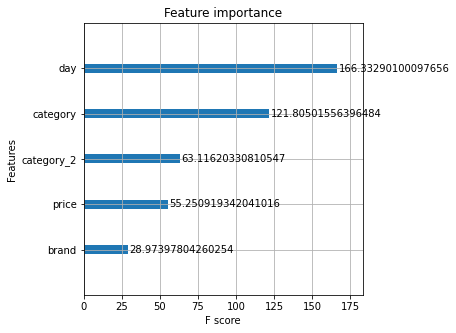

In [145]:
# Feature importance
plot_importance(xgb, max_num_features=5, importance_type ='gain')
plt.rcParams['figure.figsize'] = (5,5)
plt.show()

### Test: Reduce features based on result of feature importance

In [23]:
features.head()

,brand,price,category,day
179477,150,760.10,7,2
101887,150,358.57,7,3
99607,2300,131.76,7,3
469190,150,358.54,7,6
755707,1901,25.48,11,0


In [22]:
reduced_features = features[['day','category','price']]
reduced_features.head()

,day,category,price
179477,2,7,760.10
101887,3,7,358.57
99607,3,7,131.76
469190,6,7,358.54
755707,0,11,25.48


### Get new train-test-split

In [24]:
# Randomly assign records into training and testing sets
test_size = 0.3
X_tr, X_te, y_tr, y_te = train_test_split(reduced_features, target, test_size=test_size, random_state=123)

### Fit classifier on reduced features

In [28]:
# Fit classifer
reduc_xgb = XGBClassifier().fit(X_tr, y_tr)
y_pred_xgb_reduc = reduc_xgb.predict(X_te)

In [29]:
# Get confusion matrix
print(confusion_matrix(y_te, y_pred_xgb_reduc))

# Get classification report
print(classification_report(y_te, y_pred_xgb_reduc))

[[176884 123492]
 [ 88869 210755]]
              precision    recall  f1-score   support

           0       0.67      0.59      0.62    300376
           1       0.63      0.70      0.66    299624

    accuracy                           0.65    600000
   macro avg       0.65      0.65      0.64    600000
weighted avg       0.65      0.65      0.64    600000



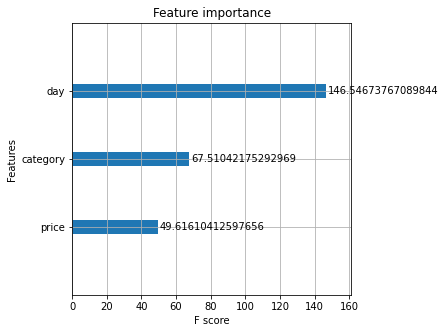

In [30]:
# Feature importance
plot_importance(reduc_xgb, max_num_features=3, importance_type ='gain')
plt.rcParams['figure.figsize'] = (5,5)
plt.show()

**Note:** No significant difference found in the model's performance metrics after the features were reduced.